In [1]:
# load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
import time
import math
import warnings

## Loading data and preprocessing

In [3]:
# Load the dataset
print("Loading dataset...")

#df = pd.read_csv('PEM_files/corrected_data.csv')  # base data                  48704, non-falls 746755
#df = pd.read_csv('PEM_files/PEM_25_07_2021.csv')  # 4478 falls
df = pd.read_csv('PEM_files/PEM_09_07_2021.csv')  # 71347, non-falls 747899; (71347, 874996) with all activities
#df = pd.read_csv('PEM_files/PEM_10_06_2021.csv')  # 47204, non-falls 727299
#df = pd.read_csv('PEM_files/PEM_11_06_2021.csv')  # 26491, non-falls 363318
#df = pd.read_csv('PEM_files/PEM_12_06_2021.csv')  # 50148, non-falls 747899
#df = pd.read_csv('PEM_files/PEM_18_06_2021.csv')  # 71347, non-falls 747899
#df = pd.read_csv('PEM_files/PEM_20_06_2021.csv')  # 71347, non-falls 747899

#df = pd.read_csv('PEM_files/PEM_Dataset_22_Users.csv')

print(len(df))

print("Dataset loaded.")

Loading dataset...
4938972
Dataset loaded.


In [4]:
# Excluding certain tasks and users that do not hold data for falls

print(f"Unique activity keys before filtering: {df['activity_key'].unique()}")
print(f"Users before filtering: {df['user'].unique()}")
print("filtering...")

df = df[df['activity_key'] != '14a']
df = df[df['activity_key'] != '16b']
df = df[df['activity_key'] != '16a']
df = df[df['activity_key'] != '18a']
df = df[df['activity_key'] != '18b']
df = df[df['activity_key'] != '3a']
df = df[df['activity_key'] != '3b']

df = df[df['user'] != 42]
df = df[df['user'] != 65]
df = df[df['user'] != 51]

print("\nfiltering complete.")
print(f"Unique activity keys after filtering:  {df['activity_key'].unique()}")
print(f"Users after filtering:  {df['user'].unique()}")
print(len(df))

Unique activity keys before filtering: ['14a' '16b' '11b' '16a' '18a' '11a' '18b' '3a' '3b']
Users before filtering: [16 17 23 39 42 44 45 47 50 51 54 56 57 59 61 63 65 67 69 71 73 75]
filtering...

filtering complete.
Unique activity keys after filtering:  ['11b' '11a']
Users after filtering:  [16 17 23 39 44 45 47 50 54 56 57 59 61 63 67 69 71 73 75]
946343


In [5]:
# Data preprocessing

print("Preprocessing data...")
# Handle missing values
#df.fillna(df.mean(), inplace=True)

# Extract the required features from the accelerometer data
df['sum_vector_magnitude'] = np.sqrt(df['zephyr_vertical']**2 + df['zephyr_lateral']**2 + df['zephyr_sagittal']**2)
df['sum_vector_magnitude_horizontal'] = np.sqrt(df['zephyr_lateral']**2 + df['zephyr_sagittal']**2)
df['angle_z_vertical'] = np.arctan2(df['zephyr_vertical'], np.sqrt(df['zephyr_lateral']**2 + df['zephyr_sagittal']**2))
df['orientation_angle_gravity'] = np.arctan2(df['zephyr_sagittal'], df['zephyr_vertical'])


Preprocessing data...


In [6]:
# Excluding heart rate 0

#print(f"Filter out {len(df[df['zephyr_heartRate'] == 0])} entries where heart rate is 0")
#df = df[df['zephyr_heartRate'] != 0]

In [7]:
# Balance the dataset
#activities = ['Falling', 'Walking', 'Lying', 'Standing Up']
#df = df[df['actionLabel'].isin(activities)]

In [8]:
df['activity_label'] = ((df["actionLabel"] == "Falling") & (df["sum_vector_magnitude"] > 1.5)).astype(int)

print(f"Unique activity labels: {df['activity_label'].unique()}")
df.head()
print("Preprocessing data complete.")

Unique activity labels: [0 1]
Preprocessing data complete.


## Feature Selection

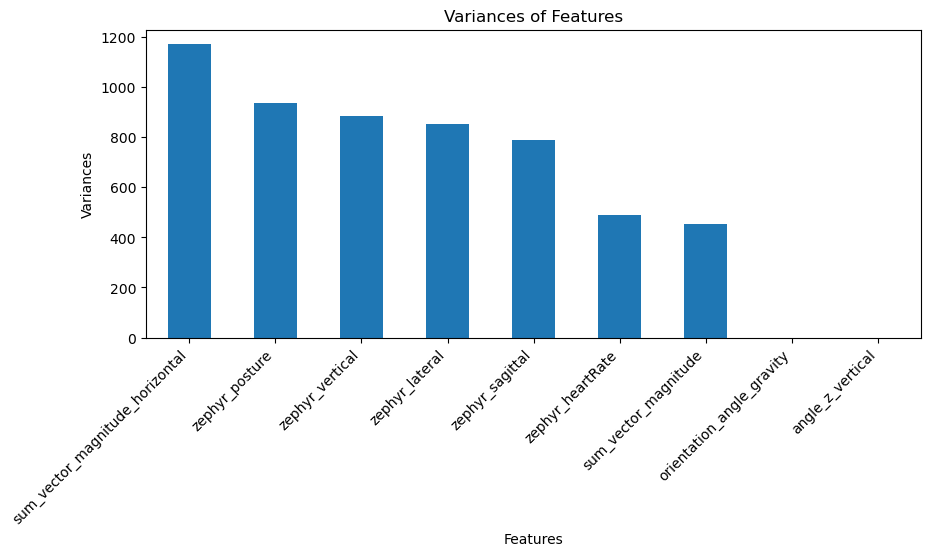

In [10]:
# Feature selection

variances = df[['sum_vector_magnitude', 'sum_vector_magnitude_horizontal', 'angle_z_vertical', 'orientation_angle_gravity', 'zephyr_heartRate', 'zephyr_posture', "zephyr_vertical", "zephyr_lateral", "zephyr_sagittal"]].var()
sorted_variances = variances.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
sorted_variances.plot(kind="bar")
plt.title("Variances of Features")
plt.xlabel("Features")
plt.ylabel("Variances")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

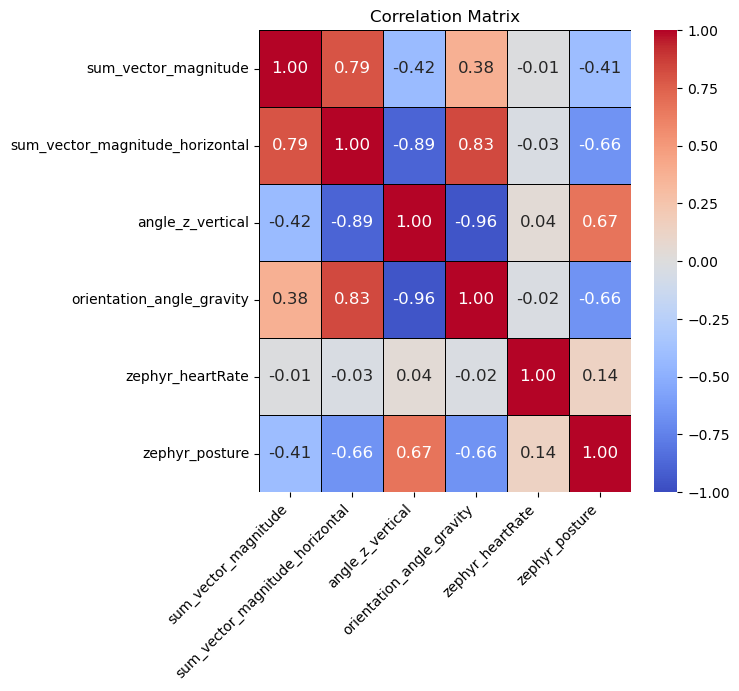

In [11]:
# Plot the correlation matrix

correlation_matrix = df[['sum_vector_magnitude', 'sum_vector_magnitude_horizontal', 'angle_z_vertical', 'orientation_angle_gravity', 'zephyr_heartRate', 'zephyr_posture']].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5, linecolor='black', annot_kws={"size": 12})
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [12]:
# Gaining insight into the data

#plt.figure(figsize=(10, 6))
#scatter = plt.scatter(df["zephyr_posture"], df["sum_vector_magnitude"], c=df["activity_label"], cmap="bwr", alpha=0.7)

#plt.xlabel("Heart Rate")
#plt.ylabel("Sum Vector Magnitude")
#plt.title("Scatter plot")
#plt.colorbar(scatter, label="Fall Detection")
#plt.show()

## Data size reduction and feature selection for training model

In [14]:
print(len(df[df["activity_label"] == 1]))
print(len(df[df["activity_label"] == 0]))

71347
874996


In [15]:
# Reduce the dataset to 4,478 falls and 941,865 no fall actions
fall_records = df[df['activity_label'] == 1]
no_fall_records = df[df['activity_label'] == 0]#.sample(n=20399, random_state=42) # n should be 941865
df = pd.concat([fall_records, no_fall_records])

# Ensure features are numeric
#X = df[['sum_vector_magnitude', 'sum_vector_magnitude_horizontal', 'angle_z_vertical', 'orientation_angle_gravity', 'zephyr_heartRate', 'zephyr_posture']]
#X = df[['zephyr_heartRate', 'zephyr_posture']]
#X = df[['zephyr_heartRate', 'zephyr_posture', "zephyr_vertical", "zephyr_lateral", "zephyr_sagittal"]]
X = df[['sum_vector_magnitude', 'sum_vector_magnitude_horizontal', 'angle_z_vertical', 'orientation_angle_gravity']]

y = df['activity_label']
print("Data preprocessing complete.")

Data preprocessing complete.


## Data set splitting

In [17]:
# Splitting the dataset into three sets
print("Starting to split data set")

print(f"Total data siz: {len(X)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Completed splitting data with sizes: training: {len(X_train)}, test: {len(X_test)}")

Starting to split data set
Total data siz: 946343
Completed splitting data with sizes: training: 662440, test: 283903


## Model training

Applying cross-validation...


############################# HYPERPARAMETERS 1 #############################


Training model with hyperparameters: {'colsample_bytree': 1, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 6, 'alpha': 0, 'gamma': 0, 'min_child_weight': 1, 'n_estimators': 100}


Elapsed time for training with hyperparameter 1: 2.86 seconds

Performance Metrics for Hyperparameters 1
Average Sensitivity: 0.16
Average Specificity: 0.99
Average Precision:   0.61
Average Accuracy:    0.93
Average FPR:         0.01
Average NPV:         0.93
Average F1 Score:    0.25
Average MCC:         0.29


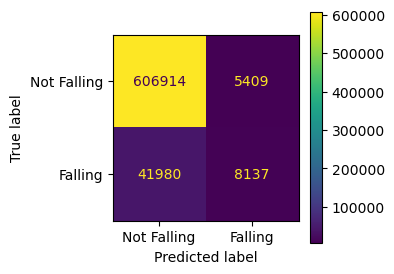



############################# HYPERPARAMETERS 2 #############################


Training model with hyperparameters: {'colsample_bytree': 0.5, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.5, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 1, 'alpha': 0, 'gamma': 2, 'min_child_weight': 1, 'n_estimators': 15}


Elapsed time for training with hyperparameter 2: 0.88 seconds

Performance Metrics for Hyperparameters 2
Average Sensitivity: 0.04
Average Specificity: 1.00
Average Precision:   0.64
Average Accuracy:    0.93
Average FPR:         0.00
Average NPV:         0.93
Average F1 Score:    0.08
Average MCC:         0.15


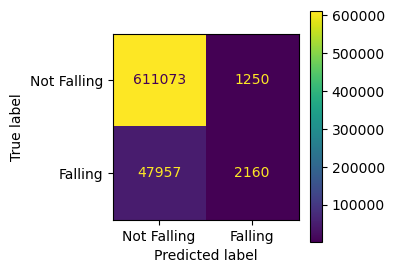



############################# HYPERPARAMETERS 3 #############################


Training model with hyperparameters: {'colsample_bytree': 0.8, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.8, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 5, 'alpha': 0, 'gamma': 2, 'min_child_weight': 1, 'n_estimators': 15}


Elapsed time for training with hyperparameter 3: 0.90 seconds

Performance Metrics for Hyperparameters 3
Average Sensitivity: 0.13
Average Specificity: 0.99
Average Precision:   0.63
Average Accuracy:    0.93
Average FPR:         0.01
Average NPV:         0.93
Average F1 Score:    0.20
Average MCC:         0.25


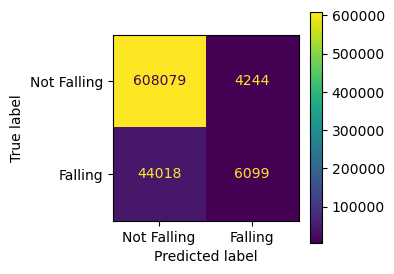



############################# HYPERPARAMETERS 4 #############################


Training model with hyperparameters: {'colsample_bytree': 1, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 10, 'alpha': 0, 'gamma': 2, 'min_child_weight': 1, 'n_estimators': 15}


Elapsed time for training with hyperparameter 4: 1.39 seconds

Performance Metrics for Hyperparameters 4
Average Sensitivity: 0.16
Average Specificity: 0.99
Average Precision:   0.60
Average Accuracy:    0.93
Average FPR:         0.01
Average NPV:         0.94
Average F1 Score:    0.25
Average MCC:         0.29


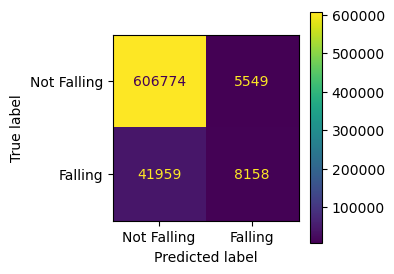



############################# HYPERPARAMETERS 5 #############################


Training model with hyperparameters: {'colsample_bytree': 0.5, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.5, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 1, 'alpha': 0, 'gamma': 0, 'min_child_weight': 1, 'n_estimators': 100}


Elapsed time for training with hyperparameter 5: 2.06 seconds

Performance Metrics for Hyperparameters 5
Average Sensitivity: 0.07
Average Specificity: 1.00
Average Precision:   0.62
Average Accuracy:    0.93
Average FPR:         0.00
Average NPV:         0.93
Average F1 Score:    0.12
Average MCC:         0.18


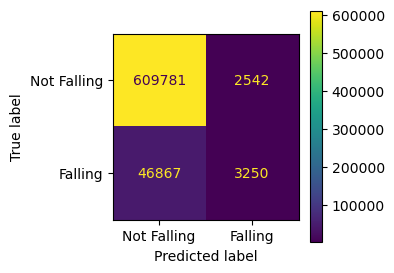



############################# HYPERPARAMETERS 6 #############################


Training model with hyperparameters: {'colsample_bytree': 1, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 1, 'alpha': 0, 'gamma': 2, 'min_child_weight': 1, 'n_estimators': 15}


Elapsed time for training with hyperparameter 6: 0.86 seconds

Performance Metrics for Hyperparameters 6
Average Sensitivity: 0.05
Average Specificity: 1.00
Average Precision:   0.65
Average Accuracy:    0.93
Average FPR:         0.00
Average NPV:         0.93
Average F1 Score:    0.08
Average MCC:         0.15


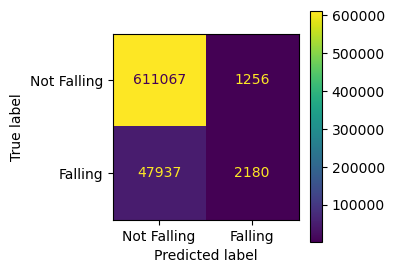


########## Best hyperparameters according to average accuracy: 1 #########

Final model training...
Final model training complete.


In [19]:
warnings.filterwarnings('ignore')  # TODO remove

# Display tree
node_params = {'shape': 'box', ## make the nodes fancy
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}


# Apply subject-independent K-Fold cross-validation
print("Applying cross-validation...")
kf = GroupKFold(n_splits=5)
group_train, group_test = train_test_split(df['user'], test_size=0.3, random_state=42)

# Hyperparameter trials 1 - 6
hyperparameter_trials = [
    {'colsample_bytree': 1, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 6, 'alpha': 0, 'gamma': 0, 'min_child_weight': 1, 'n_estimators': 100},
    {'colsample_bytree': 0.5, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.5, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 1, 'alpha': 0, 'gamma': 2, 'min_child_weight': 1, 'n_estimators': 15},
    {'colsample_bytree': 0.8, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.8, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 5, 'alpha': 0, 'gamma': 2, 'min_child_weight': 1, 'n_estimators': 15},
    {'colsample_bytree': 1, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 10, 'alpha': 0, 'gamma': 2, 'min_child_weight': 1, 'n_estimators': 15},
    {'colsample_bytree': 0.5, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.5, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 1, 'alpha': 0, 'gamma': 0, 'min_child_weight': 1, 'n_estimators': 100},
    {'colsample_bytree': 1, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'subsample': 1, 'learning_rate': 0.3, 'max_depth': 1, 'alpha': 0, 'gamma': 2, 'min_child_weight': 1, 'n_estimators': 15}
]

best_performance = 0
best_hyperparameters = None
best_model = None
best_model_number = None

# Lists to store performance metrics for each K-fold
performance_metrics = []

for params in hyperparameter_trials:
    start_time = time.time()
    print(f"\n\n############################# HYPERPARAMETERS {hyperparameter_trials.index(params) + 1} #############################\n\n")
    print(f"Training model with hyperparameters: {params}\n")
    fold_metrics = []
    for train_index, test_index in kf.split(X_train, groups=group_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Train model with the hyperparameters
        model = xgb.XGBClassifier(**params)
        model.fit(X_train_fold, y_train_fold)

        # Validate model
        y_pred_fold = model.predict(X_val_fold)

        # Calculate performance metrics\
        cm = confusion_matrix(y_val_fold, y_pred_fold, labels=[0, 1])
        #print("confusion matrix for current fold:")
        #print(cm)
        tn, fp, fn, tp = cm.ravel()
        se = tp / (tp + fn)  # Sensitivity, Recall
        sp = tn / (tn + fp)  # Specificity
        pr = tp / (tp + fp) # Precision, Positive Predictive Value (PPV)
        ac = accuracy_score(y_val_fold, y_pred_fold)  # Accuracy
        fpr = fp / (fp + tn)  # False Positive Rate
        npv = tn / (tn + fn) # Negative Predictive Value (NPV)
        f1 = (2 * pr * se) / (pr + se)
        mcc = (tp * tn - fp * fn) / math.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
        

        fold_metrics.append({
            'sensitivity': se,
            'specificity': sp,
            'accuracy': ac,
            'precision': pr,
            'fpr': fpr,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'tp': tp,
            'npv': npv,
            'f1': f1,
            'mcc': mcc
        })
    
    # Assess average performance metrics
    avg_se = np.mean([m['sensitivity'] for m in fold_metrics])
    avg_sp = np.mean([m['specificity'] for m in fold_metrics])
    avg_pr = np.mean([m['precision'] for m in fold_metrics])
    avg_ac = np.mean([m['accuracy'] for m in fold_metrics])
    avg_fpr = np.mean([m['fpr'] for m in fold_metrics])
    sum_tn = np.sum([m['tn'] for m in fold_metrics])
    sum_fp = np.sum([m['fp'] for m in fold_metrics])
    sum_fn = np.sum([m['fn'] for m in fold_metrics])
    sum_tp = np.sum([m['tp'] for m in fold_metrics])
    avg_npv = np.mean([m['npv'] for m in fold_metrics])
    avg_f1 = np.mean([m['f1'] for m in fold_metrics])
    avg_mcc = np.mean([m['mcc'] for m in fold_metrics])
    confusion_matrix_array = np.array([[sum_tn, sum_fp], [sum_fn, sum_tp]])
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nElapsed time for training with hyperparameter {hyperparameter_trials.index(params) + 1}: " + "{:.2f}".format(elapsed_time) + " seconds\n")
    
    print(f"Performance Metrics for Hyperparameters {hyperparameter_trials.index(params) + 1}")
    print(f"Average Sensitivity: " + "{:.2f}".format(avg_se))
    print(f"Average Specificity: " + "{:.2f}".format(avg_sp))
    print(f"Average Precision:   " + "{:.2f}".format(avg_pr))
    print(f"Average Accuracy:    " + "{:.2f}".format(avg_ac))
    print(f"Average FPR:         " + "{:.2f}".format(avg_fpr))
    print(f"Average NPV:         " + "{:.2f}".format(avg_npv))
    print(f"Average F1 Score:    " + "{:.2f}".format(avg_f1))
    print(f"Average MCC:         " + "{:.2f}".format(avg_mcc))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_array,
                              display_labels=["Not Falling", "Falling"])
    fig, ax = plt.subplots(figsize=(3,3))
    disp.plot(ax=ax)
    plt.show()
    #print(confusion_matrix_array)

    performance_metrics.append({
        'params': params,
        'avg_sensitivity': avg_se,
        'avg_specificity': avg_sp,
        'avg_accuracy': avg_ac,
        'avg_fpr': avg_fpr
    })

    # Select the set (trial) with the best average performance
    if avg_ac > best_performance:
        best_performance = avg_ac
        best_hyperparameters = params
        best_model = model
        best_model_number = hyperparameter_trials.index(params) + 1

print(f"\n########## Best hyperparameters according to average accuracy: {best_model_number} #########\n")
print("Final model training...")
best_model.fit(X_train, y_train)
print("Final model training complete.")

# Save the model if needed
# import joblib
# joblib.dump(best_model, 'xgboost_fall_detection_model.pkl')

In [20]:
graph_data = xgb.to_graphviz(best_model, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)
graph_data.view(filename='test_tree') ## save as PDF

'test_tree.pdf'

## Calculating Leaf Probabilities
with logistic function

In [22]:
print(1/(1+np.exp(-1*-0.208267435)))
print(1/(1+np.exp(-1*0.408672035)))

0.44812052989537215
0.6007694150488465


## Testing with new data

In [24]:
# Testing Phase

print("Evaluating model on new data...")
# Model evaluation on new data
new_df = pd.read_csv('PEM_files/new_data.csv')
#new_df.fillna(new_df.mean(), inplace=True)

# Extract the required features from the accelerometer data
new_df['sum_vector_magnitude'] = np.sqrt(new_df['zephyr_vertical']**2 + new_df['zephyr_lateral']**2 + new_df['zephyr_sagittal']**2)
new_df['sum_vector_magnitude_horizontal'] = np.sqrt(new_df['zephyr_lateral']**2 + new_df['zephyr_sagittal']**2)
new_df['angle_z_vertical'] = np.arctan2(new_df['zephyr_vertical'], np.sqrt(new_df['zephyr_lateral']**2 + new_df['zephyr_sagittal']**2))
new_df['orientation_angle_gravity'] = np.arctan2(new_df['zephyr_sagittal'], new_df['zephyr_vertical'])

new_df['activity_label'] = new_df['actionLabel'].apply(lambda x: 1 if x == 'Falling' else 0)

# Select the same features as in training the model above
# X_new = new_df[['sum_vector_magnitude', 'sum_vector_magnitude_horizontal', 'angle_z_vertical', 'orientation_angle_gravity', 'zephyr_heartRate', 'zephyr_posture']]
# X_new = new_df[['zephyr_heartRate', 'zephyr_posture']]
X_new = new_df[['sum_vector_magnitude', 'sum_vector_magnitude_horizontal', 'angle_z_vertical', 'orientation_angle_gravity']]
y_new = new_df['activity_label']

# Model prediction
y_new_pred = best_model.predict(X_new)

# Performance evaluation
tn, fp, fn, tp = confusion_matrix(y_new, y_new_pred, labels=[0, 1]).ravel()
se = recall_score(y_new, y_new_pred)  # Sensitivity
sp = tn / (tn + fp)  # Specificity
ac = accuracy_score(y_new, y_new_pred)  # Accuracy
fpr = fp / (fp + tn)  # False Positive Rate

print("Performance on new data:")
print(f"Sensitivity (SE): {se}")
print(f"Specificity (SP): {sp}")
print(f"Accuracy (AC): {ac}")
print(f"False Positive Rate (FPR): {fpr}")

# Compare the results to the performance reported in Ian's thesis
print("Comparison with results from the document:")
print(f"SE: {se} (document reported 100%)")
print(f"SP: {sp} (document reported 100%)")
print(f"AC: {ac} (document reported 100%)")
print(f"FPR: {fpr} (document reported 0%)")
print("Model evaluation complete.")

Evaluating model on new data...
Performance on new data:
Sensitivity (SE): 0.4808510638297872
Specificity (SP): 0.2613766770696232
Accuracy (AC): 0.26284891111567826
False Positive Rate (FPR): 0.7386233229303768
Comparison with results from the document:
SE: 0.4808510638297872 (document reported 100%)
SP: 0.2613766770696232 (document reported 100%)
AC: 0.26284891111567826 (document reported 100%)
FPR: 0.7386233229303768 (document reported 0%)
Model evaluation complete.
